In [1]:
import pandas as pd
import numpy as np

from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# from darts import TimeSeries
# from darts.models import AutoARIMA
# from darts.metrics import mae
# from darts.metrics import mse

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

from fbprophet import Prophet
from neuralprophet import NeuralProphet
from catboost import Pool, CatBoostRegressor

from darts.models import TFTModel

In [2]:
####### define functions

def Encoder(df):
    # This function is created to convert the object(string) to numeric values so we can use them in our machine learning models

    columnsToEncode = list(df.select_dtypes(include=['object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding ' + feature)
    return df

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# transform a time series dataset into a supervised learning dataset

    n_vars = 1
    df = pd.DataFrame(data)
    cols = list()
    
    # input sequence (t-n, ... t-1)
    for i in range(0, n_in+1):
        cols.append(df.shift(i))
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# convert to monthly
def to_monthly(df_tmp, df_y):
    # takes the df with calendar_date and df with y_values
    df2 = df_tmp[['calendar_date']].copy()
    df2['CA_TTC'] = df_y

    df2['Month_of_year'] = df2.calendar_date.dt.month
    df2['year'] = df2.calendar_date.dt.year
    
    df2 = df2.groupby(['year', 'Month_of_year'], as_index=False).agg({'CA_TTC':'sum'})
    df2["calendar_date"] = df2["year"].astype(str) + "-" + df2["Month_of_year"].astype(str)
    
    # convert calendar_date type to date_time
    df2['calendar_date'] = pd.to_datetime(df2.calendar_date)

    return df2

In [3]:
data = pd.read_csv("data_daily.csv")

In [4]:
data = data[['supplier_number', 'calendar_date', 'CA_TTC', 'dep_num', 'sub_dep_num','MSV','boni','CME','CMI','RFA']]

# convert calendar_date type to date_time
data['calendar_date'] = pd.to_datetime(data.calendar_date)

# Data Analysis

In [5]:
data.head()

,supplier_number,calendar_date,CA_TTC,dep_num,sub_dep_num,MSV,boni,CME,CMI,RFA
0,3,2020-01-08,4.00,11,2,0.12,0.000,0.0,0.0,0.0
1,3,2020-01-09,4.00,11,2,0.12,0.000,0.0,0.0,0.0
2,3,2020-01-11,37.90,11,2,26.48,4.540,0.0,0.0,0.0
3,3,2020-01-11,5.00,11,14,0.96,0.512,0.0,0.0,0.0
4,3,2020-01-14,7.95,11,2,4.46,0.430,0.0,0.0,0.0


In [6]:
# some information about the dataset
data.nunique()

supplier_number       2876
calendar_date          851
CA_TTC             1847906
dep_num                 13
sub_dep_num             49
MSV                1085779
boni                587858
CME                 278629
CMI                 331618
RFA                3311137
dtype: int64

### SUM of CA for each day of the week

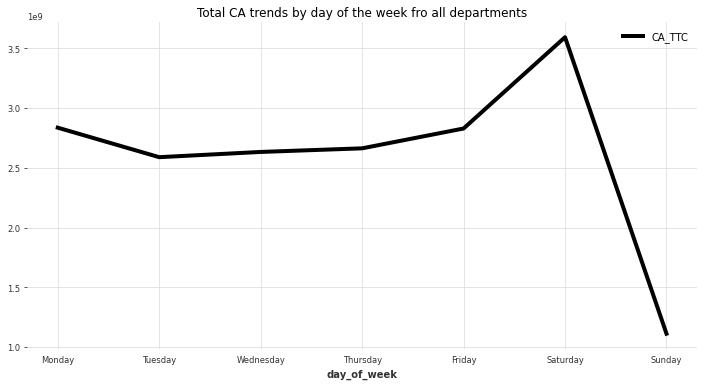

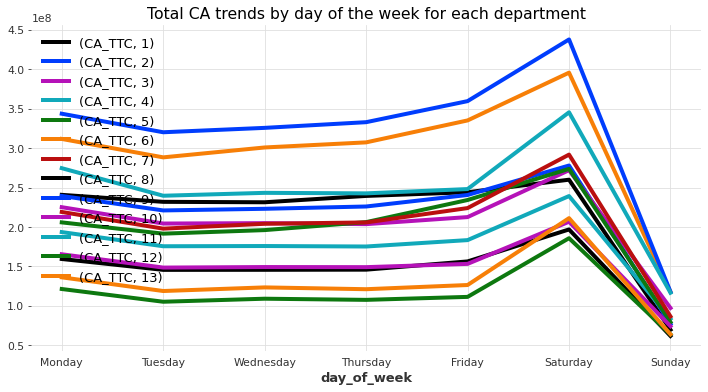

In [7]:
data['day_of_week'] = data.calendar_date.apply(lambda x: x.day_name())
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.rcParams.update({'font.size': 13})
data.groupby(['day_of_week']).agg({'CA_TTC':'sum'}).reindex(cats).plot(figsize = (12, 6), linewidth=4.0)

ticks = list(range(0, 7, 1))
# labels = "Mon Tue Wed Thu Fri Sat Sun".split()
# plt.xticks(ticks, labels)
plt.title("Total CA trends by day of the week fro all departments")
plt.show()

plt.rcParams.update({'font.size': 13})
data.groupby(['day_of_week', 'dep_num']).agg({'CA_TTC':'sum'}).unstack().reindex(cats).plot(figsize = (12, 6), linewidth=4.0)
plt.title("Total CA trends by day of the week for each department")
plt.legend(loc="upper left")
plt.show()

In [8]:
# There is not useful information in this boxplot

# fig, ax = plt.subplots(figsize = (12, 6))
# axes = data.groupby('day_of_week').boxplot(column='CA_TTC', figsize=(12, 6), color='b', subplots=False)
# axes.set_xticklabels([])

# labels = [x for x in data.groupby('day_of_week').describe().index.values]
# ticks = list(range(1, len(labels)+1, 1))
# plt.xticks(ticks, labels)

# plt.xlabel('day of week')
# plt.ylabel('CA TTC')

# plt.title('Boxplot: CA trends by days of week')
# plt.show()

### Mean of CA for each day of month

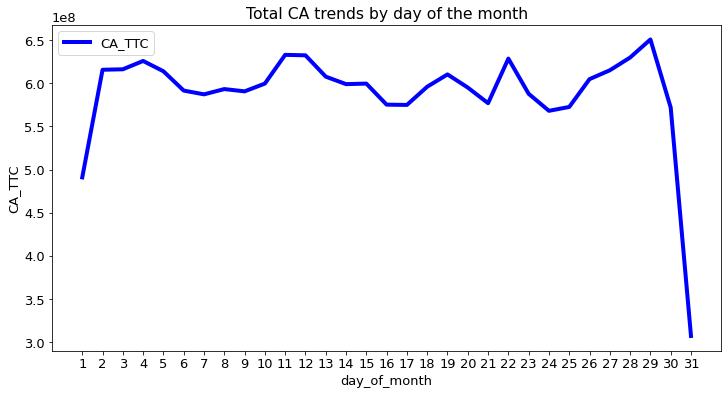

In [48]:
data['day_of_month'] = data.calendar_date.apply(lambda x: x.day)

plt.rcParams.update({'font.size': 13})

data.groupby('day_of_month').agg({'CA_TTC':'sum'}).plot(figsize = (12, 6), color = 'b', linewidth=4.0)
ticks = list(range(1, 32, 1))
plt.xticks(ticks)
plt.title("Total CA trends by day of the month")

plt.xlabel('day_of_month')
plt.ylabel('CA_TTC')

plt.show()

In [10]:
## ram problem: cannot load all data so we skip it
# fig, ax = plt.subplots(figsize = (12, 6))

# axes = data.groupby('day_of_month').boxplot(column='CA_TTC', figsize=(12, 6), color='b', subplots=False)
# axes.set_xticklabels([])

# ticks = list(range(1, 32, 1))
# labels = range(1, 32)

# plt.xticks(ticks, labels)

# plt.xlabel('day of months')
# plt.ylabel('CA TTC')

# plt.title('Boxplot: CA trends by days of month')
# plt.show()

### SUM of CA for each month of the year

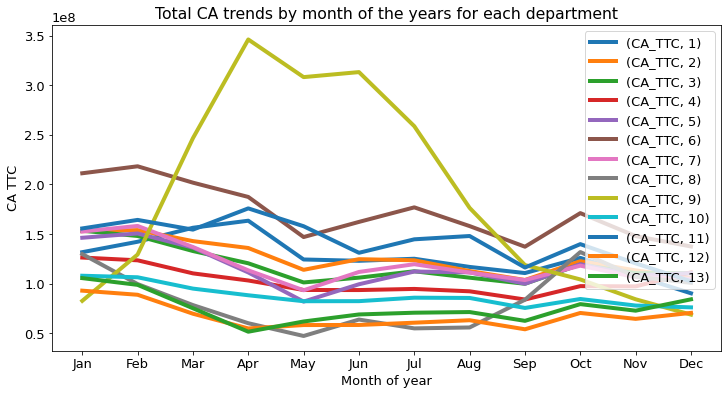

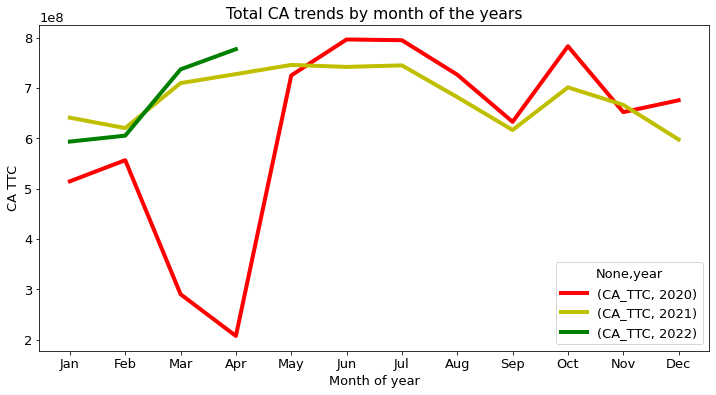

In [53]:
data['Month_of_year'] = data.calendar_date.apply(lambda x: x.month_name())
data['year'] = data.calendar_date.dt.year
cats = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.rcParams.update({'font.size': 13})
data.groupby(['Month_of_year', 'dep_num']).agg({'CA_TTC':'sum'}).unstack().reindex(cats).plot(figsize=(12,6), linewidth=4)
ticks = list(range(0, 12, 1)) # points on the x axis where you want the label to appear
labels = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split()
plt.xticks(ticks, labels)
plt.title("Total CA trends by month of the years for each department")
plt.xlabel('Month of year')
plt.ylabel('CA TTC')
plt.legend(loc="upper right")
plt.show()

plt.rcParams.update({'font.size': 13})
data.groupby(['Month_of_year', 'year']).agg({'CA_TTC':'sum'}).unstack().reindex(cats).plot(figsize=(12,6), color=['r', 'y', 'g'], subplots=False, linewidth = 4)
ticks = list(range(0, 12, 1)) # points on the x axis where you want the label to appear
labels = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split()
plt.xticks(ticks, labels)
plt.title("Total CA trends by month of the years")
plt.xlabel('Month of year')
plt.ylabel('CA TTC')
plt.show()

In [12]:
# data['day_of_week'] = data.calendar_date.apply(lambda x: x.day_name())
# cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# data.groupby(['day_of_week']).agg({'CA_TTC':'sum'}).reindex(cats).plot(figsize = (12, 6))

# ticks = list(range(0, 7, 1))
# labels = "Mon Tue Wed Thu Fri Sat Sun".split()
# plt.xticks(ticks, labels)
# plt.title("Total CA trends by day of the week fro all departments")
# plt.show()


# data.groupby(['year', 'day_of_week', 'dep_num']).agg({'CA_TTC':'sum'}).unstack().reindex().plot(figsize = (15, 8))
# plt.title("Total CA trends by day of the week for each department")
# plt.show()

In [13]:
# # ram problem
# fig, ax = plt.subplots(figsize=(12,6))

# axes = data.groupby('Month_of_year').boxplot(column='CA_TTC', figsize=(12,6), color='b', subplots=False)

# axes.set_xticklabels([])

# plt.ylabel('CA TTC')

# labels = [x for x in data.groupby('Month_of_year').describe().index.values]
# ticks = list(range(1, len(labels)+1, 1))
# plt.xticks(ticks, labels)

# plt.xlabel('Months of year')

# plt.title('Boxplot: CA trends by month of year');
# plt.show() 

## Observation
* Is there estimation for other parameters such as RFA that be used in ML algorithm?

* WEEK: people buy in Satuarday more than other days while Sunday is close
* MONTH: end of the month people buy more because maybe they got their salary
* YEAR: 2022 is stricktly ascending till April. Also, in 2021, the data in May has the most CA.
* Rayon 9 different behavior (March to September).
* Odd behavior in 2020 (could it be Corona? )

## Makeing the models

In [96]:
# specifying the supplier that we want to predict its Sales (CA)
sup_num = 523 # GARDENA 
# sup_num = 4646 # V33 

### Prophet

In [97]:
# preparing the data
# we use one month as test (cut_date)
current_date = data.calendar_date.max()
cut_date = pd.to_datetime((current_date - pd.Timedelta(days=65)), format="%Y%m") + MonthEnd(0)

data_fb = data[data['supplier_number'] == sup_num]
data_fb = data_fb.groupby(['supplier_number', 'calendar_date'], as_index=False).agg({'CA_TTC':'sum', 'MSV':'sum', 'boni':'sum', 'CME':'sum', 'CMI':'sum', 'RFA':'sum', 'year':'max'})

In [98]:
# create train and test
train_prophet = data_fb[(data_fb.calendar_date <= cut_date) & (data_fb.year >= 2019)].copy()

test_prophet = data_fb[(data_fb.calendar_date > cut_date)].copy()
len_real_data_4test = len(test_prophet)

test_prophet_tmp = pd.DataFrame({'calendar_date':pd.date_range(data_fb.calendar_date.max() + pd.Timedelta(days=1), periods=365, freq='d'), 'CA_TTC':0})
test_prophet = test_prophet.append(test_prophet_tmp, ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_21884\1941743979.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_prophet = test_prophet.append(test_prophet_tmp, ignore_index=True)

  test_prophet = test_prophet.append(test_prophet_tmp, ignore_index=True)



In [99]:
# Create the model
model_prophet = Prophet(yearly_seasonality=True)
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# fit train data to the model
model_prophet.fit(train_prophet.rename(columns={'calendar_date':'ds', 'CA_TTC':'y'}))

# Predict on training set with model
prediction_prophet = model_prophet.predict(df=test_prophet.reset_index().rename(columns={'calendar_date':'ds'}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will b

In [100]:
# also create model for Neural Prophet
data_train_np = train_prophet[['calendar_date', 'CA_TTC']].rename(columns={'calendar_date':'ds', 'CA_TTC':'y'})
data_test_np = test_prophet[['calendar_date', 'CA_TTC']].rename(columns={'calendar_date':'ds', 'CA_TTC':'y'})

model_nprophet = NeuralProphet()

metrics = model_nprophet.fit(data_train_np, freq="D")

prediction_nprophet = model_nprophet.predict(data_test_np)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.588% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 98.588% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 210
INFO:NP.config:Auto-set epochs to 210


  0%|          | 0/123 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.86E-01, min: 4.36E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.86E-01, min: 4.36E-01


  0%|          | 0/123 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.86E-01, min: 5.17E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.86E-01, min: 5.17E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.51E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.51E-01
Epoch[210/210]: 100%|█████| 210/210 [00:14<00:00, 14.98it/s, SmoothL1Loss=0.0092, MAE=1.18e+4, RMSE=1.67e+4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.765% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.765% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.765% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal t

In [101]:
# model_nprophet.plot(prediction_nprophet);
# model_nprophet.plot_components(prediction_nprophet);
# model_nprophet.plot_parameters();

In [102]:
# compute MAE and MSE for the predicted months

# total predicted CA for the month
ca_m_p = prediction_prophet.yhat[:len_real_data_4test]
ca_m_np = prediction_nprophet.yhat1[:len_real_data_4test]

# total actual CA for the month
ca_m_a = test_prophet.CA_TTC[:len_real_data_4test]

# evaluate forecasts
mae = mean_absolute_error(ca_m_p, ca_m_a)
mae_n = mean_absolute_error(ca_m_np, ca_m_a)
print('Test MAE Prohpet: %.3f' % mae)
print('Test MAE Neural Prohpet: %.3f' % mae_n)

mse = mean_squared_error(ca_m_p, ca_m_a)
mse_n = mean_squared_error(ca_m_np, ca_m_a)
print('Test MSE Prohpet: %.3f' % mse)
print('Test MSE Neural Prohpet: %.3f' % mse_n)

rmse = mean_squared_error(ca_m_p, ca_m_a, squared=False)
rmse_n = mean_squared_error(ca_m_np, ca_m_a, squared=False)
print('Test RMSE Prophet: %.3f' % rmse)
print('Test RMSE Neural Prophet: %.3f' % rmse_n)

Test MAE Prohpet: 32006.051
Test MAE Neural Prohpet: 30765.951
Test MSE Prohpet: 1590198616.321
Test MSE Neural Prohpet: 1423588684.730
Test RMSE Prophet: 39877.294
Test RMSE Neural Prophet: 37730.474


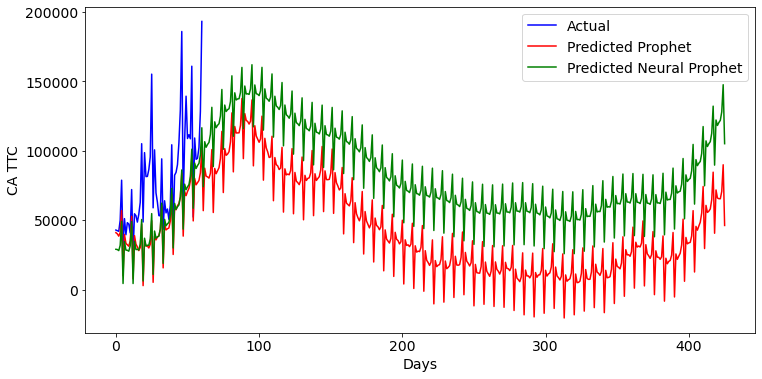

In [103]:
# plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(test_prophet.CA_TTC[:len_real_data_4test], color='b', label="Actual")
plt.plot(prediction_prophet.yhat, color='red', label="Predicted Prophet")
plt.plot(prediction_nprophet.yhat1, color='g', label="Predicted Neural Prophet")
plt.legend(loc="upper right")

plt.xlabel('Days')
plt.ylabel('CA TTC')

plt.show()

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)



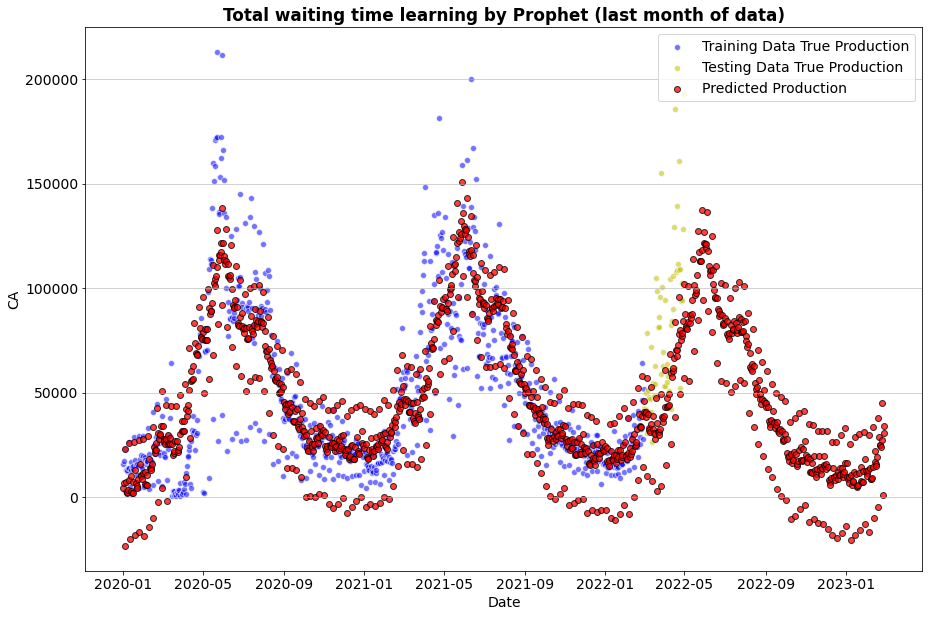

In [104]:
# Prophet: leanring with make_future function
future = model_prophet.make_future_dataframe(periods=365, freq='d')
forecast = model_prophet.predict(future)

# look at the result in a differnt way 
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 14})

plt.scatter(train_prophet['calendar_date'], train_prophet['CA_TTC'], color='b',alpha=.55,edgecolor='w',label='Training Data True Production')
plt.scatter(test_prophet['calendar_date'][:len_real_data_4test],test_prophet['CA_TTC'][:len_real_data_4test],color='y',alpha=.55,edgecolor='w',label='Testing Data True Production')
plt.scatter(forecast['ds'],forecast['yhat'],color='r',alpha=.75,edgecolor='k',label='Predicted Production')

# plt.xlim(pd.to_datetime('2021-10-01'), pd.to_datetime('2021-11-01'))
plt.ylabel('CA')
plt.xlabel('Date')
plt.legend()
plt.grid(axis='y',alpha=.7)
plt.title("Total waiting time learning by Prophet (last month of data)",fontweight='bold')
plt.show()

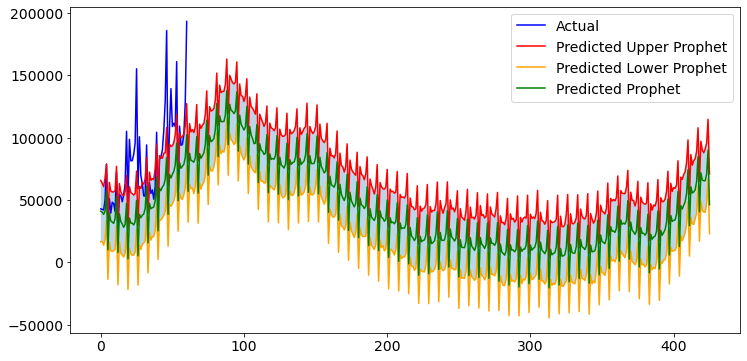

In [105]:
# plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(test_prophet.CA_TTC[:len_real_data_4test], color='b', label="Actual")
plt.plot(prediction_prophet.yhat_upper, color='red', label="Predicted Upper Prophet")
plt.plot(prediction_prophet.yhat_lower, color='orange', label="Predicted Lower Prophet")
plt.plot(prediction_prophet.yhat, color='green', label="Predicted Prophet")
plt.fill_between(range(len(test_prophet)), prediction_prophet.yhat_upper, prediction_prophet.yhat_lower, alpha=0.3)

plt.legend(loc="upper right")
plt.show()

In [106]:
prediction_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-01,49309.243721,16532.529028,65786.044390,49309.243721,49309.243721,-8301.918977,-8301.918977,-8301.918977,3975.223887,...,-224.090092,-224.090092,-224.090092,-12053.052771,-12053.052771,-12053.052771,0.0,0.0,0.0,41007.324744
1,2022-03-02,49282.604596,16765.078179,63494.710525,49282.604596,49282.604596,-9114.433270,-9114.433270,-9114.433270,3065.439397,...,-343.506046,-343.506046,-343.506046,-11836.366621,-11836.366621,-11836.366621,0.0,0.0,0.0,40168.171326
2,2022-03-03,49255.965471,13764.200554,60743.716852,49255.965471,49255.965471,-10745.605530,-10745.605530,-10745.605530,1932.674758,...,-961.493804,-961.493804,-961.493804,-11716.786484,-11716.786484,-11716.786484,0.0,0.0,0.0,38510.359940
3,2022-03-04,49229.326345,18101.115589,67781.464152,49229.326345,49229.326345,-8202.252457,-8202.252457,-8202.252457,813.245134,...,2679.886282,2679.886282,2679.886282,-11695.383873,-11695.383873,-11695.383873,0.0,0.0,0.0,41027.073888
4,2022-03-05,49202.687220,33675.674626,78704.449461,49202.687220,49202.687220,7716.094759,7716.094759,7716.094759,-241.589822,...,19729.196330,19729.196330,19729.196330,-11771.511749,-11771.511749,-11771.511749,0.0,0.0,0.0,56918.781978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,2023-04-26,38094.171963,40451.623361,87941.099401,33383.036720,42804.086404,27403.563213,27403.563213,27403.563213,-449.826758,...,-343.506045,-343.506045,-343.506045,28196.896016,28196.896016,28196.896016,0.0,0.0,0.0,65497.735176
422,2023-04-27,38067.532838,40177.991787,91014.640727,33332.568445,42789.513832,27398.640078,27398.640078,27398.640078,-437.235595,...,-961.493804,-961.493804,-961.493804,28797.369477,28797.369477,28797.369477,0.0,0.0,0.0,65466.172915
423,2023-04-28,38040.893712,47019.143354,95514.610114,33282.100171,42789.015574,32713.155764,32713.155764,32713.155764,673.554518,...,2679.886282,2679.886282,2679.886282,29359.714964,29359.714964,29359.714964,0.0,0.0,0.0,70754.049476
424,2023-04-29,38014.254587,67076.269997,114764.515708,33231.631896,42788.405691,51952.049213,51952.049213,51952.049213,2320.715848,...,19729.196330,19729.196330,19729.196330,29902.137036,29902.137036,29902.137036,0.0,0.0,0.0,89966.303801


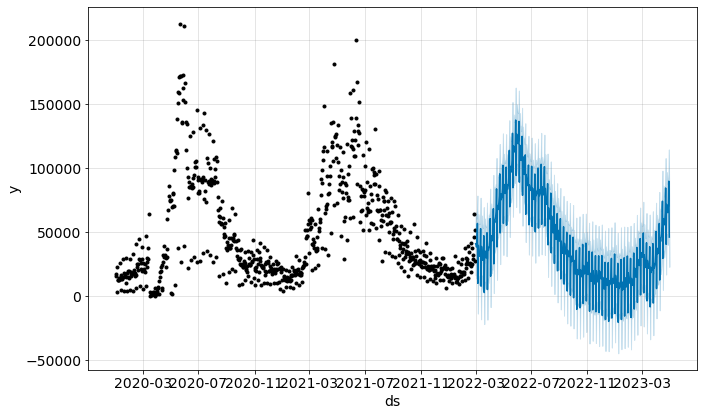

In [107]:
model_prophet.plot(prediction_prophet);

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)

  components = components.append(new_comp)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\Anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append

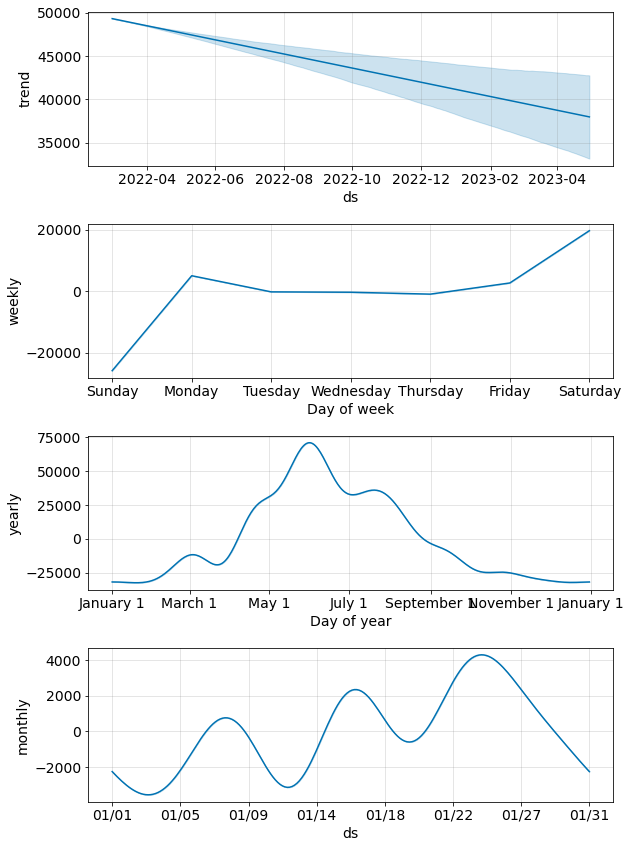

In [108]:
model_prophet.plot_components(prediction_prophet);

In [109]:
# Convert To monthly
upper_monthly = to_monthly(test_prophet, prediction_prophet.yhat_upper)
lower_monthly = to_monthly(test_prophet, prediction_prophet.yhat_lower)
predictions_prophet_monthly = to_monthly(test_prophet, prediction_prophet.yhat)
test_prophet_monthly = to_monthly(test_prophet, test_prophet.CA_TTC)
predictions_nprophet_monthly = to_monthly(test_prophet, prediction_nprophet.yhat1)

# len_real_data_4test_monthly = len(test_cb_monthly[test_cb_monthly.CA_TTC>0])
# model_cb_quantile_5_monthly = to_monthly(test_cb, model_cb_ranged_pred[0])

len_real_data_4test_monthly = len(test_prophet_monthly[test_prophet_monthly.CA_TTC>0])

# erase the negative CA
lower_monthly[lower_monthly.CA_TTC<0] = 0

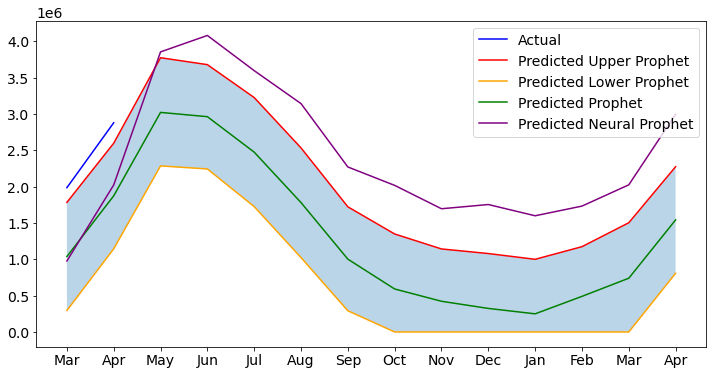

In [110]:
# plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(test_prophet_monthly.CA_TTC[:len_real_data_4test_monthly], color='b', label="Actual")
plt.plot(upper_monthly.CA_TTC, color='red', label="Predicted Upper Prophet")
plt.plot(lower_monthly.CA_TTC, color='orange', label="Predicted Lower Prophet")
plt.plot(predictions_prophet_monthly.CA_TTC, color='green', label="Predicted Prophet")
plt.plot(predictions_nprophet_monthly.CA_TTC, color='purple', label="Predicted Neural Prophet")
plt.fill_between(range(len(test_prophet_monthly)), upper_monthly.CA_TTC, lower_monthly.CA_TTC, alpha=0.3)

m_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
labels = [m_names[i-1] for i in test_prophet_monthly.Month_of_year]
plt.xticks(range(len(test_prophet_monthly)), labels)

plt.legend(loc="upper right")
plt.show()

### CatBoost Model

In [111]:
# first take the full data
new_df = data[data['supplier_number'] == sup_num]
new_df = new_df.groupby(['calendar_date'], as_index=False).agg({'CA_TTC':'sum'})
new_df['year'] = new_df.calendar_date.dt.year
new_df['Month_of_year'] = new_df['calendar_date'].dt.month
new_df['day_of_week'] = new_df['calendar_date'].dt.dayofweek
new_df['day_of_month'] = new_df.calendar_date.apply(lambda x: x.day)

In [112]:
# create train and test
train_cb = new_df[(new_df.calendar_date <= cut_date) & (new_df.year >= 2020)].copy()
test_cb = new_df[(new_df.calendar_date > cut_date)].copy()
# test_cb = new_df[(new_df.calendar_date > cut_date) & (new_df.calendar_date <= cut_date + MonthEnd(1))].copy()\
len_real_data_4test = len(test_cb)

train_cb_y = train_cb['CA_TTC']
train_cb = train_cb.drop('CA_TTC', 1)

test_cb_y = test_cb['CA_TTC'].reset_index(drop=True)
test_cb = test_cb.drop('CA_TTC', 1)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_21884\1798945533.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_cb = train_cb.drop('CA_TTC', 1)

  train_cb = train_cb.drop('CA_TTC', 1)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_21884\1798945533.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_cb = test_cb.drop('CA_TTC', 1)

  test_cb = test_cb.drop('CA_TTC', 1)



In [113]:
### test for one year
new_test_date = test_cb.calendar_date.max() + pd.Timedelta(days=1)
test_cb = new_df[(new_df.calendar_date > cut_date)].copy()

test_cb_tmp = pd.DataFrame({'calendar_date':pd.date_range(new_test_date, periods=365, freq='d'), 'CA_TTC':0})
test_cb_tmp.calendar_date = test_cb_tmp.calendar_date + pd.Timedelta(days=1)
test_cb_tmp['year'] = test_cb_tmp.calendar_date.dt.year
test_cb_tmp['Month_of_year'] = test_cb_tmp['calendar_date'].dt.month
test_cb_tmp['day_of_week'] = test_cb_tmp['calendar_date'].dt.dayofweek
test_cb_tmp['day_of_month'] = test_cb_tmp.calendar_date.apply(lambda x: x.day)

test_cb = test_cb.append(test_cb_tmp, ignore_index=True)

test_cb_y = test_cb['CA_TTC'].reset_index(drop=True)
test_cb = test_cb.drop('CA_TTC', 1)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_21884\2342859117.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_cb = test_cb.append(test_cb_tmp, ignore_index=True)

  test_cb = test_cb.append(test_cb_tmp, ignore_index=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_21884\2342859117.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_cb = test_cb.drop('CA_TTC', 1)

  test_cb = test_cb.drop('CA_TTC', 1)



In [114]:
# creating the model
model_cb = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, loss_function='RMSE')

# train the model
model_cb.fit(train_cb, train_cb_y, verbose=False)

# making the prediction
predictions_cb = model_cb.predict(test_cb)

In [115]:
# evaluate forecasts

# total predicted CA for the month
ca_m_p_cb = predictions_cb[:len_real_data_4test]
# print("predicted CA:", ca_m_p)

# total actual CA for the month
ca_m_a_cb = test_cb_y[:len_real_data_4test]
# print("Actual CA:", ca_m_a)

mae_cb = mean_absolute_error(ca_m_a_cb, ca_m_p_cb)
print('Test MAE CatBoost: %.3f' % mae_cb)

mse_cb = mean_squared_error(ca_m_a_cb, ca_m_p_cb)
print('Test MSE CatBoost: %.3f' % mse_cb)

rmse = mean_squared_error(ca_m_a_cb, ca_m_p_cb, squared=False)
print('Test RMSE CatBoost: %.3f' % rmse)

Test MAE CatBoost: 19553.050
Test MSE CatBoost: 764379527.053
Test RMSE CatBoost: 27647.414


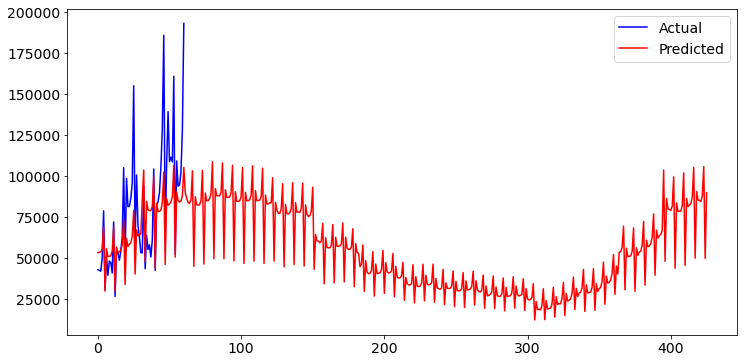

In [116]:
# plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(test_cb_y[:len_real_data_4test], color='b', label="Actual")
plt.plot(predictions_cb, color='red', label="Predicted")
plt.legend(loc="upper right")
plt.show()

In [117]:
######### Computer upper and lower bound for catboost
# Note: model_cb_ranged_pred[0] contains the quartile = 0.5

model_cb_ranged = [CatBoostRegressor(loss_function='Quantile:alpha=0.5')]
model_cb_ranged[0].fit(train_cb, train_cb_y, verbose=False)
model_cb_ranged_pred = [model_cb_ranged[0].predict(test_cb)]

itr = 1
for i in np.arange(0.1, 1, 0.1):
    print('Quantile:alpha='+str(i))
    model_cb_ranged.append(CatBoostRegressor(loss_function='Quantile:alpha='+str(i)))
    model_cb_ranged[itr].fit(train_cb, train_cb_y, verbose=False)
    tmp = [model_cb_ranged[itr].predict(test_cb)]
    model_cb_ranged_pred.append(tmp)

    itr = itr + 1

Quantile:alpha=0.1
Quantile:alpha=0.2
Quantile:alpha=0.30000000000000004
Quantile:alpha=0.4
Quantile:alpha=0.5
Quantile:alpha=0.6
Quantile:alpha=0.7000000000000001
Quantile:alpha=0.8
Quantile:alpha=0.9


In [118]:
# Note: model_cb_ranged_pred[0] contains the quartile = 0.5
model_cb_ranged = [CatBoostRegressor(loss_function='Quantile:alpha=0.5')]
model_cb_ranged[0].fit(train_cb, train_cb_y, verbose=False)
model_cb_ranged_pred = np.empty([len(model_cb_ranged_pred), len(test_cb_y)])
model_cb_ranged_pred[0, :] = np.array(model_cb_ranged[0].predict(test_cb))

itr = 1
for i in np.arange(0.1, 1, 0.1):
    model_cb_ranged.append(CatBoostRegressor(loss_function='Quantile:alpha='+str(i)))
    model_cb_ranged[itr].fit(train_cb, train_cb_y, verbose=False)
    model_cb_ranged_pred[itr, :] = np.array(model_cb_ranged[itr].predict(test_cb))

    itr = itr + 1
    
# compute the upper and lower prediction bounds
upper = np.zeros(len(test_cb_y))
lower = np.zeros(len(test_cb_y))
for i in range(len(test_cb_y)):
    upper[i] = max(model_cb_ranged_pred[:, i])
    lower[i] = min(model_cb_ranged_pred[:, i])


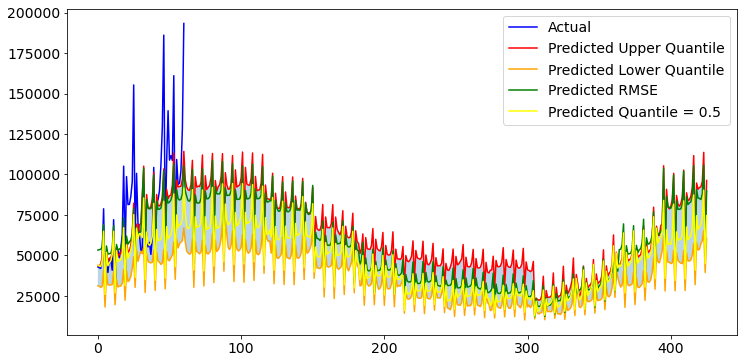

In [119]:
# plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(test_cb_y[:len_real_data_4test], color='b', label="Actual")
plt.plot(upper, color='red', label="Predicted Upper Quantile")
plt.plot(lower, color='orange', label="Predicted Lower Quantile")
plt.plot(predictions_cb, color='green', label="Predicted RMSE")
plt.plot(model_cb_ranged_pred[0], color='yellow', label="Predicted Quantile = 0.5")
plt.fill_between(range(len(test_cb_y)), upper, lower, alpha=0.3)

plt.legend(loc="upper right")
plt.show()

In [120]:
#### convert daily to monthly for catboost
n_of_months = len(test_prophet_monthly)

upper_monthly_cb = to_monthly(test_cb, upper)[:n_of_months]
lower_monthly_cb = to_monthly(test_cb, lower)[:n_of_months]
predictions_cb_monthly = to_monthly(test_cb, predictions_cb)[:n_of_months]
test_cb_monthly = to_monthly(test_cb, test_cb_y)[:n_of_months]
len_real_data_4test_monthly = len(test_cb_monthly[test_cb_monthly.CA_TTC>0])
model_cb_quantile_5_monthly = to_monthly(test_cb, model_cb_ranged_pred[0])[:n_of_months]

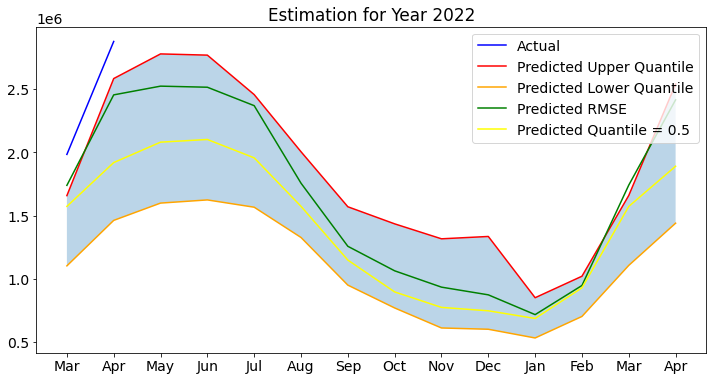

In [121]:
# plot forecasts against actual outcomes
plt.figure(figsize=(12, 6))
plt.plot(test_cb_monthly.CA_TTC[:len_real_data_4test_monthly], color='b', label="Actual")
plt.plot(upper_monthly_cb.CA_TTC, color='red', label="Predicted Upper Quantile")
plt.plot(lower_monthly_cb.CA_TTC, color='orange', label="Predicted Lower Quantile")
plt.plot(predictions_cb_monthly.CA_TTC, color='green', label="Predicted RMSE")
plt.plot(model_cb_quantile_5_monthly.CA_TTC, color='yellow', label="Predicted Quantile = 0.5")
plt.fill_between(range(len(test_cb_monthly)), upper_monthly_cb.CA_TTC, lower_monthly_cb.CA_TTC, alpha=0.3)

m_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
labels = [m_names[i-1] for i in test_cb_monthly.Month_of_year]
plt.xticks(range(len(test_cb_monthly)), labels)
plt.title("Estimation for Year 2022")

plt.legend(loc="upper right")
plt.show()

## Plot all methods

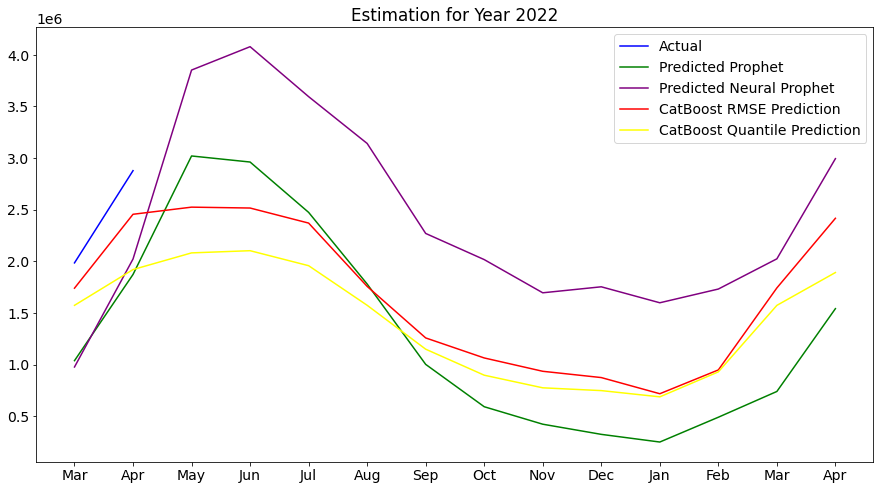

In [122]:
# plot forecasts against actual outcomes
plt.figure(figsize=(15, 8))
plt.plot(test_prophet_monthly.CA_TTC[:len_real_data_4test_monthly], color='b', label="Actual")
# plt.plot(upper_monthly.CA_TTC, color='red', label="Predicted Upper Prophet")
# plt.plot(lower_monthly.CA_TTC, color='orange', label="Predicted Lower Prophet")
plt.plot(predictions_prophet_monthly.CA_TTC, color='green', label="Predicted Prophet")
plt.plot(predictions_nprophet_monthly.CA_TTC, color='purple', label="Predicted Neural Prophet")
# plt.fill_between(range(len(test_prophet_monthly)), upper_monthly.CA_TTC, lower_monthly.CA_TTC, alpha=0.3)
plt.plot(predictions_cb_monthly.CA_TTC, color='red', label="CatBoost RMSE Prediction")
plt.plot(model_cb_quantile_5_monthly.CA_TTC, color='yellow', label="CatBoost Quantile Prediction")

m_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
labels = [m_names[i-1] for i in test_prophet_monthly.Month_of_year]
plt.title("Estimation for Year 2022")
plt.xticks(range(len(test_prophet_monthly)), labels)

plt.legend(loc="upper right")
plt.show()


# Cumulative view monthly

In [123]:
upper_monthly = to_monthly(test_prophet, prediction_prophet.yhat_upper)
lower_monthly = to_monthly(test_prophet, prediction_prophet.yhat_lower)
predictions_prophet_monthly = to_monthly(test_prophet, prediction_prophet.yhat)
test_prophet_monthly = to_monthly(test_prophet, test_prophet.CA_TTC)

# len_real_data_4test_monthly = len(test_cb_monthly[test_cb_monthly.CA_TTC>0])
# model_cb_quantile_5_monthly = to_monthly(test_cb, model_cb_ranged_pred[0])

len_real_data_4test_monthly = len(test_prophet_monthly[test_prophet_monthly.CA_TTC>0])

In [124]:
# cumulative view base on prophet algorithm

# first convert train and test data to monthly
train_prophet_monthly = to_monthly(train_prophet, train_prophet.CA_TTC)
test_prophet_monthly = to_monthly(test_prophet, test_prophet.CA_TTC)
data_fb_monthly = to_monthly(data_fb, data_fb.CA_TTC)

tmp = prediction_prophet[['ds', 'yhat_lower']]
tmp.columns = ['calendar_date', 'CA_TTC']
prediction_prophet_lower_monthly = to_monthly(tmp, tmp.CA_TTC)

tmp = prediction_prophet[['ds', 'yhat_upper']]
tmp.columns = ['calendar_date', 'CA_TTC']
prediction_prophet_upper_monthly = to_monthly(tmp, tmp.CA_TTC)

train_max_year = train_prophet_monthly.calendar_date.max().year
train_max_month = train_prophet_monthly.calendar_date.max().month



data_com_yhat = data_fb_monthly[data_fb_monthly.calendar_date.dt.year >= train_max_year].reset_index(drop=True)
data_com_yhat = data_com_yhat[['calendar_date', 'CA_TTC']]

df_tmp = predictions_prophet_monthly[['calendar_date', 'CA_TTC']]
df_tmp = df_tmp[(df_tmp.calendar_date > data_com_yhat.calendar_date.max()) & (df_tmp.calendar_date.dt.year <= train_max_year)]

data_com_yhat = data_com_yhat.append(df_tmp).reset_index(drop=True)


############# compute for lower and upper case now
### lower
data_com_yhat_lower = data_fb_monthly[data_fb_monthly.calendar_date.dt.year >= train_max_year].reset_index(drop=True)
data_com_yhat_lower = data_com_yhat_lower[['calendar_date', 'CA_TTC']]

df_tmp = prediction_prophet_lower_monthly[['calendar_date', 'CA_TTC']]
df_tmp = df_tmp[(df_tmp.calendar_date > data_com_yhat_lower.calendar_date.max()) & (df_tmp.calendar_date.dt.year <= train_max_year)]
data_com_yhat_lower = data_com_yhat_lower.append(df_tmp).reset_index(drop=True)

### Upper
data_com_yhat_upper = data_fb_monthly[data_fb_monthly.calendar_date.dt.year >= train_max_year].reset_index(drop=True)
data_com_yhat_upper = data_com_yhat_upper[['calendar_date', 'CA_TTC']]

df_tmp = prediction_prophet_upper_monthly[['calendar_date', 'CA_TTC']]
df_tmp = df_tmp[(df_tmp.calendar_date > data_com_yhat_upper.calendar_date.max()) & (df_tmp.calendar_date.dt.year <= train_max_year)]
data_com_yhat_upper = data_com_yhat_upper.append(df_tmp).reset_index(drop=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_21884\1099892928.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_com_yhat = data_com_yhat.append(df_tmp).reset_index(drop=True)

  data_com_yhat = data_com_yhat.append(df_tmp).reset_index(drop=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_21884\1099892928.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_com_yhat_lower = data_com_yhat_lower.append(df_tmp).reset_index(drop=True)

  data_com_yhat_lower = data_com_yhat_lower.append(df_tmp).reset_index(drop=True)

WARNING - (py.warnings._showwarnmsg) - C:\Users\10159513\AppData\Local\Temp\ipykernel_21884\1099892928.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

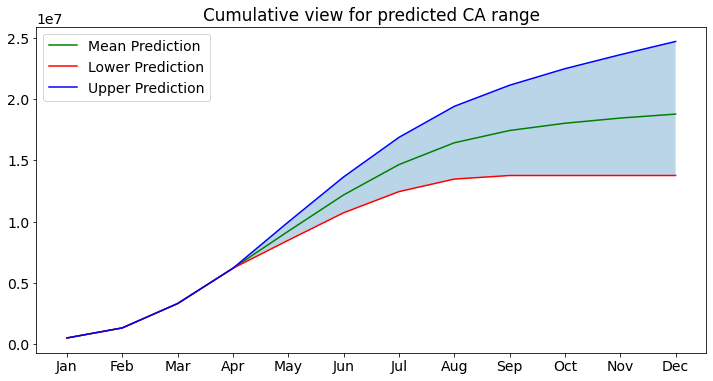

In [128]:
# convert negative CA to 0 because we wont have negative ones

data_lower_non_negative = data_com_yhat_lower.copy()
data_lower_non_negative[data_lower_non_negative.CA_TTC<0] = 0

lower_plt = np.cumsum(data_lower_non_negative.CA_TTC)
mean_plt = np.cumsum(data_com_yhat.CA_TTC)
upper_plt = np.cumsum(data_com_yhat_upper.CA_TTC)


plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 14})

plt.plot(mean_plt, label = 'Mean Prediction', color='g')
plt.plot(lower_plt, label = 'Lower Prediction', color='r')
plt.plot(upper_plt, label = 'Upper Prediction', color='b')
plt.fill_between(range(len(lower_plt)), lower_plt, upper_plt, alpha=0.3)

labels = "Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec".split()
ticks = list(range(0, 12, 1))
plt.xticks(ticks, labels)
plt.legend(loc="upper left")
plt.title('Cumulative view for predicted CA range')
plt.show()